In [1]:
%matplotlib inline
%config Completer.use_jedi = False


# Plotting data from a file

Plotting CPU usage values


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np
import pandas as pd

from glob import glob
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

Load the data
============

In [3]:
state_transitions = pd.read_csv('state_snapshots_adaptive_2021_02_01.csv')
state_transitions.head()

,name,time,placementAction,cpuUsageMetrics,cpuFreqMetrics,arrivalRate,throughput,placementType,proxyNumaDistances
0,state_snapshots,1612168470521000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.097, 0.016, 0.258, 0.015, 0.316, 0.446, 0.9...","[1438.74, 1242.16, 2100.68, 1200.17, 2101.73, ...",16876.416667,148113.16,0,"[0.15887581912344984, 0.5295600073985345, 0.47..."
1,state_snapshots,1612168500419000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.005, 0.036, 0.024, 0.962, 0.069, 0.026, 0.0...","[2100.31, 2100.59, 1545.47, 2100.13, 1836.46, ...",36303.850000,320069.15,3,"[0.15969760464123556, 0.5324522286940669, 0.47..."
2,state_snapshots,1612168530407000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.007, 0.007, 0.468, 0.982, 0.022, 0.013, 0.9...","[2098.94, 2100.37, 2099.29, 2100.13, 2100.39, ...",38690.166667,342455.17,3,"[0.15935843618098755, 0.5314108958083108, 0.47..."
3,state_snapshots,1612168560411000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.005, 0.069, 0.036, 0.009, 0.035, 0.011, 0.0...","[1869.75, 2100.14, 2098.9, 2100.21, 2100.14, 2...",38326.200000,339404.95,3,"[0.15780005349886927, 0.5260754161169906, 0.47..."
4,state_snapshots,1612168590410000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.004, 0.045, 0.007, 0.011, 0.29, 0.011, 0.03...","[2100.82, 2102.11, 2101.05, 2100.19, 2100.13, ...",36186.200000,319340.90,3,"[0.47826404333312367, 0.49646518467435086, 0.4..."


In [4]:
start_time = state_transitions['time'].iloc[0]
placement_actions = state_transitions.placementAction.str.strip(
    '[]').str.split(',', expand=True).astype(int)
placement_actions = placement_actions.add_prefix('v')
n_vertices = placement_actions.shape[1]

proxy_numa_distances = state_transitions.proxyNumaDistances.str.strip(
    '[]').str.split(',', expand=True).astype(float)
proxy_numa_distances = proxy_numa_distances.add_prefix('numa_')
proxy_numa_distances['numaSum'] = proxy_numa_distances.sum(axis=1)

cpu_freq_metrics = state_transitions.cpuFreqMetrics.str.strip(
    '[]').str.split(',', expand=True).astype(float)
cpu_freq_metrics = proxy_numa_distances.add_prefix('freq_')

for op_column in placement_actions:
    one_hot_encoded_placement = pd.get_dummies(placement_actions[op_column], prefix= "op_" + op_column + "_cpu")
    placement_actions = placement_actions.join(one_hot_encoded_placement)
cpu_metrics = state_transitions.cpuUsageMetrics.str.strip('[]').str.split(',', expand=True)
cpu_metrics = cpu_metrics.add_prefix('cpu_')
processed_state_transitions = state_transitions.join(placement_actions).join(
    cpu_freq_metrics).join(cpu_metrics).join(proxy_numa_distances)
processed_state_transitions['relTime'] =  ((processed_state_transitions['time'] - 
                                            start_time)/30_000_000_000).round().astype(int)
processed_state_transitions

,name,time,placementAction,cpuUsageMetrics,cpuFreqMetrics,arrivalRate,throughput,placementType,proxyNumaDistances,v0,...,numa_58,numa_59,numa_60,numa_61,numa_62,numa_63,numa_64,numa_65,numaSum,relTime
0,state_snapshots,1612168470521000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.097, 0.016, 0.258, 0.015, 0.316, 0.446, 0.9...","[1438.74, 1242.16, 2100.68, 1200.17, 2101.73, ...",16876.416667,148113.16,0,"[0.15887581912344984, 0.5295600073985345, 0.47...",1,...,0.616093,0.266664,0.066669,1.000000,0.399990,0.399990,1.000000,0.985700,38.094807,0
1,state_snapshots,1612168500419000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.005, 0.036, 0.024, 0.962, 0.069, 0.026, 0.0...","[2100.31, 2100.59, 1545.47, 2100.13, 1836.46, ...",36303.850000,320069.15,3,"[0.15969760464123556, 0.5324522286940669, 0.47...",2,...,0.626378,0.266662,0.066662,1.000000,0.399987,0.399980,1.000000,0.999313,38.166010,1
2,state_snapshots,1612168530407000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.007, 0.007, 0.468, 0.982, 0.022, 0.013, 0.9...","[2098.94, 2100.37, 2099.29, 2100.13, 2100.39, ...",38690.166667,342455.17,3,"[0.15935843618098755, 0.5314108958083108, 0.47...",19,...,0.625991,0.227365,0.056836,0.852623,0.341038,0.341028,0.738927,0.999960,37.042586,2
3,state_snapshots,1612168560411000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.005, 0.069, 0.036, 0.009, 0.035, 0.011, 0.0...","[1869.75, 2100.14, 2098.9, 2100.21, 2100.14, 2...",38326.200000,339404.95,3,"[0.15780005349886927, 0.5260754161169906, 0.47...",14,...,0.604339,0.210426,0.178072,0.789092,0.315630,0.315627,0.683889,0.966120,36.973344,3
4,state_snapshots,1612168590410000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.004, 0.045, 0.007, 0.011, 0.29, 0.011, 0.03...","[2100.82, 2102.11, 2101.05, 2100.19, 2100.13, ...",36186.200000,319340.90,3,"[0.47826404333312367, 0.49646518467435086, 0.4...",14,...,0.750012,0.198586,0.049646,0.744711,0.714297,0.523803,0.645414,0.903106,36.966952,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,state_snapshots,1612182630588000000,"[23, 11, 8, 6, 10, 2, 1, 20, 0, 16, 18, 22, 17...","[0.559, 0.04, 0.017, 0.994, 0.002, 0.008, 0.00...","[2100.13, 2100.23, 2100.43, 2100.13, 2100.41, ...",31097.983333,286733.88,1,"[0.26068040804746573, 0.46316101099063756, 0.8...",23,...,0.573551,0.914812,0.267991,0.960457,0.569834,0.281251,0.728531,0.957148,45.935025,472
360,state_snapshots,1612182690600000000,"[21, 19, 18, 7, 20, 3, 2, 14, 0, 4, 1, 5, 17, ...","[0.027, 0.268, 0.97, 0.027, 0.008, 0.011, 0.06...","[2100.81, 2099.96, 2093.07, 2100.23, 1694.33, ...",37482.583333,337603.32,1,"[0.4225750081206544, 0.48497781725032585, 0.61...",21,...,0.808611,0.657186,0.391330,0.711162,0.649980,0.668869,0.616336,0.999975,44.838477,474
361,state_snapshots,1612182720482000000,"[14, 4, 15, 13, 5, 2, 1, 20, 0, 16, 18, 22, 17...","[0.015, 0.268, 0.989, 0.013, 0.004, 0.006, 0.0...","[2100.7, 2099.58, 2100.13, 2100.3, 2100.5, 210...",36725.583333,337751.36,1,"[0.26068040804746573, 0.46316101099063756, 0.8...",14,...,0.897729,0.914812,0.267991,0.960457,0.569834,0.281251,0.728531,0.884703,46.066497,475
362,state_snapshots,1612182750588000000,"[23, 11, 8, 6, 10, 2, 1, 20, 0, 16, 18, 22, 17...","[0.015, 0.26, 0.985, 0.015, 0.006, 0.017, 0.06...","[2048.01, 2100.97, 2100.13, 2078.12, 1994.28, ...",36590.583333,336933.07,1,"[0.26068040804746573, 0.46316101099063756, 0.8...",23,...,0.573551,0.914812,0.267991,0.960457,0.569834,0.281251,0.728531,0.957148,45.935025,476


In [5]:
def cpu_freq_avg(x):
    placement_actions = x['placementAction'].strip('[]').split(',')
    indices = np.array([int(placement.strip()) for placement in placement_actions])
    freq_metrics_arr = np.array([float(freq.strip()) for freq in x['cpuFreqMetrics'].strip('[]').split(',')])
    selected_freqs = freq_metrics_arr[indices]
    return round(np.mean(selected_freqs),2)

In [6]:
placementTypeNames = {0:'Default',1:'Predicted-First',2:'Predicted-Other',3:'Random',4:'Naive'}
placementTypeColors = {'Default':'C3','Predicted-First':'C0','Predicted-Other':'C5','Random':'C1','Naive':'C2'}
plot_state_transitions = processed_state_transitions.loc[:,['relTime','cpuFreqMetrics', 'placementAction',
                                                            'placementType',
                                                            'arrivalRate','throughput','numaSum']]
plot_state_transitions['placementTypeName'] = plot_state_transitions['placementType'].map(placementTypeNames)
plot_state_transitions['placementTypeColor'] = plot_state_transitions['placementTypeName'].map(placementTypeColors)
plot_state_transitions['placementActionAugmented'] = plot_state_transitions[
    'relTime'].astype(str) + " : " + plot_state_transitions['placementAction'] 
plot_state_transitions['numaSumTime'] = plot_state_transitions[
    'relTime'].astype(str) + " : " + plot_state_transitions['numaSum'].round(1).astype(str)
plot_state_transitions['cpuFreqAvg'] = plot_state_transitions.apply(cpu_freq_avg, axis=1)
plot_state_transitions['throughputRatio'] = plot_state_transitions['throughput'] / plot_state_transitions[
    'arrivalRate']    
plot_state_transitions

,relTime,cpuFreqMetrics,placementAction,placementType,arrivalRate,throughput,numaSum,placementTypeName,placementTypeColor,placementActionAugmented,numaSumTime,cpuFreqAvg,throughputRatio
0,0,"[1438.74, 1242.16, 2100.68, 1200.17, 2101.73, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,16876.416667,148113.16,38.094807,Default,C3,"0 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0 : 38.1,1838.86,8.776339
1,1,"[2100.31, 2100.59, 1545.47, 2100.13, 1836.46, ...","[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...",3,36303.850000,320069.15,38.166010,Random,C1,"1 : [2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4,...",1 : 38.2,1945.94,8.816397
2,2,"[2098.94, 2100.37, 2099.29, 2100.13, 2100.39, ...","[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...",3,38690.166667,342455.17,37.042586,Random,C1,"2 : [19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1...",2 : 37.0,2072.31,8.851220
3,3,"[1869.75, 2100.14, 2098.9, 2100.21, 2100.14, 2...","[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...",3,38326.200000,339404.95,36.973344,Random,C1,"3 : [14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18...",3 : 37.0,2028.99,8.855690
4,4,"[2100.82, 2102.11, 2101.05, 2100.19, 2100.13, ...","[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...",3,36186.200000,319340.90,36.966952,Random,C1,"4 : [14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, ...",4 : 37.0,2037.35,8.824936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,472,"[2100.13, 2100.23, 2100.43, 2100.13, 2100.41, ...","[23, 11, 8, 6, 10, 2, 1, 20, 0, 16, 18, 22, 17...",1,31097.983333,286733.88,45.935025,Predicted-First,C0,"472 : [23, 11, 8, 6, 10, 2, 1, 20, 0, 16, 18, ...",472 : 45.9,2077.33,9.220337
360,474,"[2100.81, 2099.96, 2093.07, 2100.23, 1694.33, ...","[21, 19, 18, 7, 20, 3, 2, 14, 0, 4, 1, 5, 17, ...",1,37482.583333,337603.32,44.838477,Predicted-First,C0,"474 : [21, 19, 18, 7, 20, 3, 2, 14, 0, 4, 1, 5...",474 : 44.8,2056.76,9.006938
361,475,"[2100.7, 2099.58, 2100.13, 2100.3, 2100.5, 210...","[14, 4, 15, 13, 5, 2, 1, 20, 0, 16, 18, 22, 17...",1,36725.583333,337751.36,46.066497,Predicted-First,C0,"475 : [14, 4, 15, 13, 5, 2, 1, 20, 0, 16, 18, ...",475 : 46.1,2100.33,9.196623
362,476,"[2048.01, 2100.97, 2100.13, 2078.12, 1994.28, ...","[23, 11, 8, 6, 10, 2, 1, 20, 0, 16, 18, 22, 17...",1,36590.583333,336933.07,45.935025,Predicted-First,C0,"476 : [23, 11, 8, 6, 10, 2, 1, 20, 0, 16, 18, ...",476 : 45.9,2080.03,9.208191


In [7]:
plot_state_transitions_filtered = plot_state_transitions.nlargest(15, 'throughputRatio')
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', None)  
top_n_placements = pd.DataFrame(plot_state_transitions_filtered['placementAction'].str.strip(
    '[]').str.split(',', expand=True).astype(int)).add_prefix('Op_').join(
    plot_state_transitions_filtered).drop(columns=['placementType','placementTypeColor','placementAction',
                                                   'placementActionAugmented','numaSumTime','cpuFreqMetrics'])
top_n_placements.to_csv('top_n_placements.csv')
top_n_placements

,Op_0,Op_1,Op_2,Op_3,Op_4,Op_5,Op_6,Op_7,Op_8,Op_9,Op_10,Op_11,Op_12,Op_13,Op_14,Op_15,Op_16,relTime,arrivalRate,throughput,numaSum,placementTypeName,cpuFreqAvg,throughputRatio
99,18,7,20,19,8,3,2,14,0,4,1,5,17,15,12,13,16,126,38954.283333,361179.38,43.504164,Predicted-First,1730.17,9.271878
87,6,7,18,20,19,3,2,14,1,4,0,5,17,15,12,13,16,110,37920.783333,351561.62,42.992167,Predicted-First,1765.59,9.270948
135,18,21,8,19,20,3,2,14,0,4,1,5,17,15,12,13,16,174,35142.016667,325790.30,44.199792,Predicted-First,2100.56,9.270677
84,22,18,21,20,19,3,2,14,0,4,1,5,17,15,12,13,16,106,38994.566667,361499.61,42.866012,Random,1624.05,9.270512
234,18,7,20,6,19,3,2,14,0,4,1,5,17,15,12,13,16,306,32068.050000,297254.77,44.338659,Predicted-First,1996.54,9.269499
336,18,20,19,6,7,3,2,14,0,4,1,5,17,15,12,13,16,442,37123.433333,344105.04,45.206927,Predicted-First,1796.62,9.269214
207,19,6,18,20,7,3,2,14,0,4,1,5,17,16,12,13,15,270,31547.433333,292414.09,43.922235,Predicted-First,1820.42,9.269029
126,18,7,19,6,20,3,2,14,0,4,1,5,17,15,12,13,16,162,37413.350000,346718.00,43.578316,Predicted-First,1938.38,9.267227
132,6,18,19,20,7,3,2,14,0,4,1,5,17,15,12,13,16,170,31298.500000,290047.30,43.578316,Random,1927.47,9.267131
350,23,11,8,6,10,2,1,20,0,16,18,22,17,3,12,19,21,460,35591.416667,329826.70,45.888526,Predicted-First,1756.51,9.267029


In [8]:
plot_state_transitions_filtered_smallest = plot_state_transitions.nsmallest(45, 'throughputRatio')
bottom_n_placements = pd.DataFrame(plot_state_transitions_filtered_smallest['placementAction'].str.strip(
    '[]').str.split(',', expand=True).astype(int)).add_prefix('Op_').join(
    plot_state_transitions_filtered_smallest).drop(columns=['placementType','placementTypeColor',
                                                            'placementAction','placementActionAugmented',
                                                            'numaSumTime','cpuFreqMetrics'])
bottom_n_placements.to_csv('bottom_n_placements.csv')
bottom_n_placements

,Op_0,Op_1,Op_2,Op_3,Op_4,Op_5,Op_6,Op_7,Op_8,Op_9,Op_10,Op_11,Op_12,Op_13,Op_14,Op_15,Op_16,relTime,arrivalRate,throughput,numaSum,placementTypeName,cpuFreqAvg,throughputRatio
18,13,22,21,14,17,20,9,12,5,11,4,10,8,18,15,3,23,18,29082.366667,253299.71,34.298744,Random,1855.66,8.709735
15,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,15,27976.250000,244168.91,36.313919,Naive,1842.96,8.727721
14,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,14,28892.550000,252429.01,36.313919,Naive,1848.39,8.736820
19,8,21,14,11,18,4,20,0,2,9,5,19,15,1,16,13,10,19,30496.100000,266635.40,35.980508,Random,1904.40,8.743262
20,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,20,31102.516667,272185.87,37.072860,Naive,1750.06,8.751249
17,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,17,33255.416667,291149.95,36.882576,Naive,1756.91,8.754963
16,10,11,18,2,3,15,6,20,8,12,19,1,21,23,7,17,9,16,32004.900000,280628.34,38.377669,Random,2100.51,8.768293
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,0,16876.416667,148113.16,38.094807,Default,1838.86,8.776339
5,0,3,11,1,13,14,22,10,9,2,17,19,18,20,4,6,8,5,34394.400000,302531.12,32.685789,Random,2100.51,8.795941
13,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,13,34187.133333,301282.61,36.313919,Naive,1810.57,8.812749


In [9]:
#df.sort_values(columns, ascending=True).head(n)
plot_state_transitions_sorted = plot_state_transitions.sort_values('throughputRatio',ascending=False)
sorted_n_placements = pd.DataFrame(plot_state_transitions_sorted['placementAction'].str.strip(
    '[]').str.split(',', expand=True).astype(int)).add_prefix('Op_').join(
    plot_state_transitions_sorted).drop(columns=['placementType','placementTypeColor',
                                                            'placementAction','placementActionAugmented',
                                                            'numaSumTime','cpuFreqMetrics'])
sorted_n_placements.to_csv('sorted_n_placements.csv')
sorted_n_placements


,Op_0,Op_1,Op_2,Op_3,Op_4,Op_5,Op_6,Op_7,Op_8,Op_9,Op_10,Op_11,Op_12,Op_13,Op_14,Op_15,Op_16,relTime,arrivalRate,throughput,numaSum,placementTypeName,cpuFreqAvg,throughputRatio
99,18,7,20,19,8,3,2,14,0,4,1,5,17,15,12,13,16,126,38954.283333,361179.38,43.504164,Predicted-First,1730.17,9.271878
87,6,7,18,20,19,3,2,14,1,4,0,5,17,15,12,13,16,110,37920.783333,351561.62,42.992167,Predicted-First,1765.59,9.270948
135,18,21,8,19,20,3,2,14,0,4,1,5,17,15,12,13,16,174,35142.016667,325790.30,44.199792,Predicted-First,2100.56,9.270677
84,22,18,21,20,19,3,2,14,0,4,1,5,17,15,12,13,16,106,38994.566667,361499.61,42.866012,Random,1624.05,9.270512
234,18,7,20,6,19,3,2,14,0,4,1,5,17,15,12,13,16,306,32068.050000,297254.77,44.338659,Predicted-First,1996.54,9.269499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,20,31102.516667,272185.87,37.072860,Naive,1750.06,8.751249
19,8,21,14,11,18,4,20,0,2,9,5,19,15,1,16,13,10,19,30496.100000,266635.40,35.980508,Random,1904.40,8.743262
14,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,14,28892.550000,252429.01,36.313919,Naive,1848.39,8.736820
15,0,12,18,6,19,7,20,8,21,9,22,23,11,10,1,13,2,15,27976.250000,244168.91,36.313919,Naive,1842.96,8.727721


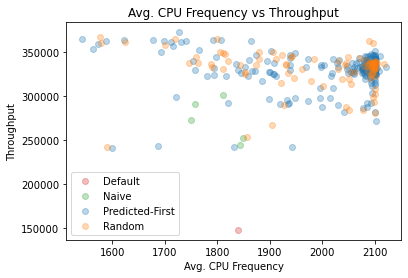

In [37]:
scatter_x = plot_state_transitions['cpuFreqAvg']
scatter_y = plot_state_transitions['throughput']
group = plot_state_transitions['placementTypeName']

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = plot_state_transitions.index[plot_state_transitions['placementTypeName'] == g].tolist()
    ax.scatter(scatter_x[ix], scatter_y[ix], c = placementTypeColors[g], label = g, alpha=0.3)
ax.set_title("Avg. CPU Frequency vs Throughput")
ax.set_xlabel("Avg. CPU Frequency")
ax.set_ylabel("Throughput")    
ax.legend()
plt.savefig('cpu_freq_vs_througput.png')
plt.show()


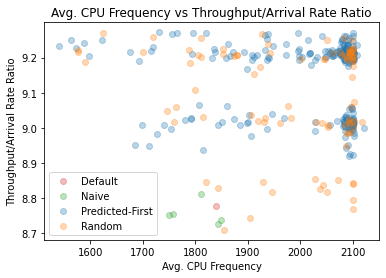

In [38]:
scatter_x = plot_state_transitions['cpuFreqAvg']
scatter_y = plot_state_transitions['throughput'] / plot_state_transitions['arrivalRate']
group = plot_state_transitions['placementTypeName']

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = plot_state_transitions.index[plot_state_transitions['placementTypeName'] == g].tolist()
    ax.scatter(scatter_x[ix], scatter_y[ix], c = placementTypeColors[g], label = g, alpha=0.3)
ax.set_title("Avg. CPU Frequency vs Throughput/Arrival Rate Ratio")
ax.set_xlabel("Avg. CPU Frequency")
ax.set_ylabel("Throughput/Arrival Rate Ratio")    
ax.legend()
plt.savefig('cpu_freq_vs_througput_ratio.png')
plt.show()

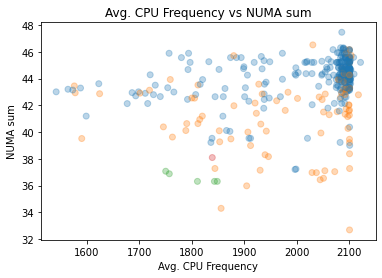

In [12]:
plt.scatter(plot_state_transitions['cpuFreqAvg'], 
            plot_state_transitions['numaSum'], 
            c=plot_state_transitions['placementTypeColor'], alpha=0.3)
plt.title("Avg. CPU Frequency vs NUMA sum")
plt.xlabel("Avg. CPU Frequency")
plt.ylabel("NUMA sum")
plt.savefig('cpu_freq_vs_numa_sum.png')
plt.show()

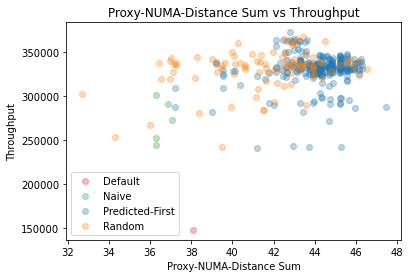

In [39]:
scatter_x = plot_state_transitions['numaSum']
scatter_y = plot_state_transitions['throughput']
group = plot_state_transitions['placementTypeName']

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = plot_state_transitions.index[plot_state_transitions['placementTypeName'] == g].tolist()
    ax.scatter(scatter_x[ix], scatter_y[ix], c = placementTypeColors[g], label = g, alpha=0.3)
ax.set_title("Proxy-NUMA-Distance Sum vs Throughput")
ax.set_xlabel("Proxy-NUMA-Distance Sum")
ax.set_ylabel("Throughput")    
ax.legend()
plt.savefig('proxy_numa_sum_vs_througput.png')
plt.show()

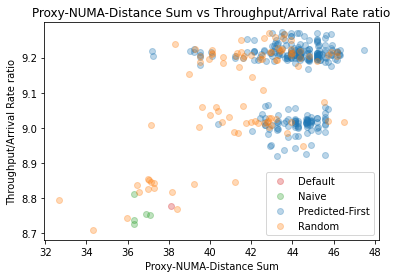

In [40]:
scatter_x = plot_state_transitions['numaSum']
scatter_y = plot_state_transitions['throughput'] / plot_state_transitions['arrivalRate']
group = plot_state_transitions['placementTypeName']

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = plot_state_transitions.index[plot_state_transitions['placementTypeName'] == g].tolist()
    ax.scatter(scatter_x[ix], scatter_y[ix], c = placementTypeColors[g], label = g, alpha=0.3)
ax.set_title("Proxy-NUMA-Distance Sum vs Throughput/Arrival Rate ratio")
ax.set_xlabel("Proxy-NUMA-Distance Sum")
ax.set_ylabel("Throughput/Arrival Rate ratio")    
ax.legend()
plt.savefig('proxy_numa_sum_vs_througput_ratio.png')
plt.show()

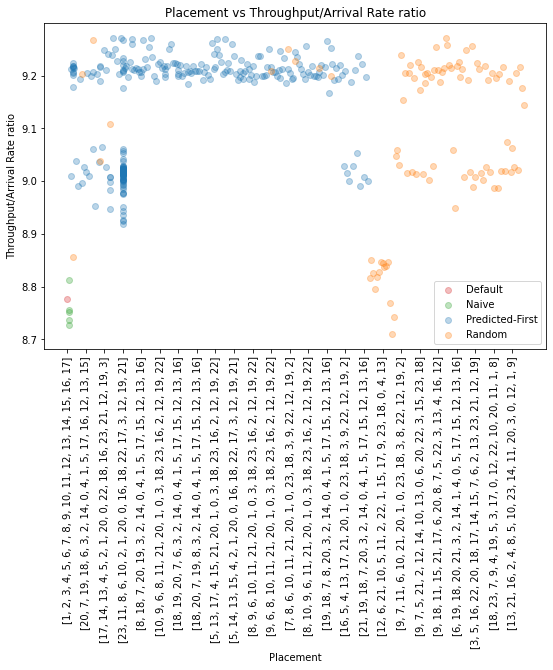

In [45]:
scatter_x = plot_state_transitions['placementAction']
scatter_y = plot_state_transitions['throughput'] / plot_state_transitions['arrivalRate']
group = plot_state_transitions['placementTypeName']

fig, ax = plt.subplots(figsize=(9,6))
for g in np.unique(group):
    ix = plot_state_transitions.index[plot_state_transitions['placementTypeName'] == g].tolist()
    ax.scatter(scatter_x[ix], scatter_y[ix], c = placementTypeColors[g], label = g, alpha=0.3)
ax.set_title("Placement vs Throughput/Arrival Rate ratio")
ax.set_xlabel("Placement")
ax.set_ylabel("Throughput/Arrival Rate ratio")    
ax.legend(loc = 'lower right')
xtick_locs, xtick_labels = plt.xticks()
plt.xticks(xtick_locs[::10], rotation=90)
plt.savefig('placement_vs_througput_arrival_rate_ratio.png')
plt.show()

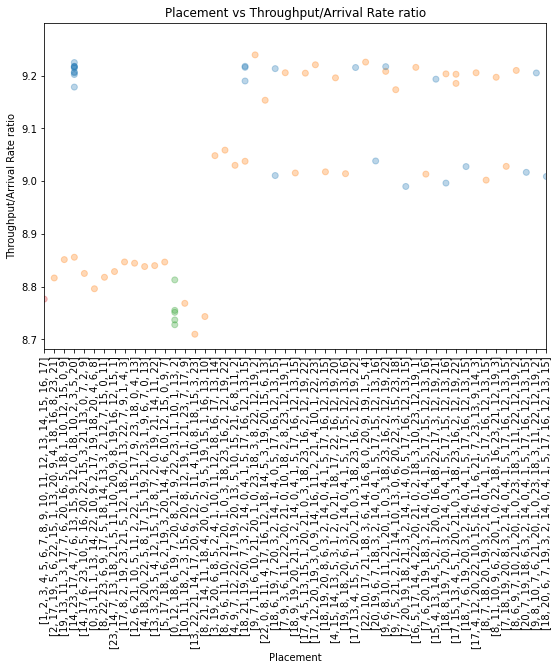

In [16]:
plt.figure(figsize=(9,6))
plt.scatter(plot_state_transitions['placementAction'], 
            plot_state_transitions['throughput'] / plot_state_transitions['arrivalRate'], 
            c=plot_state_transitions['placementTypeColor'], alpha=0.3)
plt.title("Placement vs Throughput/Arrival Rate ratio")
plt.xlabel("Placement")
plt.ylabel("Throughput/Arrival Rate ratio")
xtick_locs, xtick_labels = plt.xticks()
plt.xticks(xtick_locs, rotation=90)
plt.xlim(0,50)
plt.savefig('placement_shortened_vs_througput_arrival_rate_ratio.png')
plt.show()

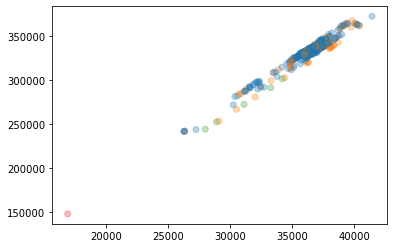

In [17]:
plt.scatter(plot_state_transitions['arrivalRate'],plot_state_transitions['throughput'],  
            c=plot_state_transitions['placementTypeColor'], alpha=0.3)
plt.show()

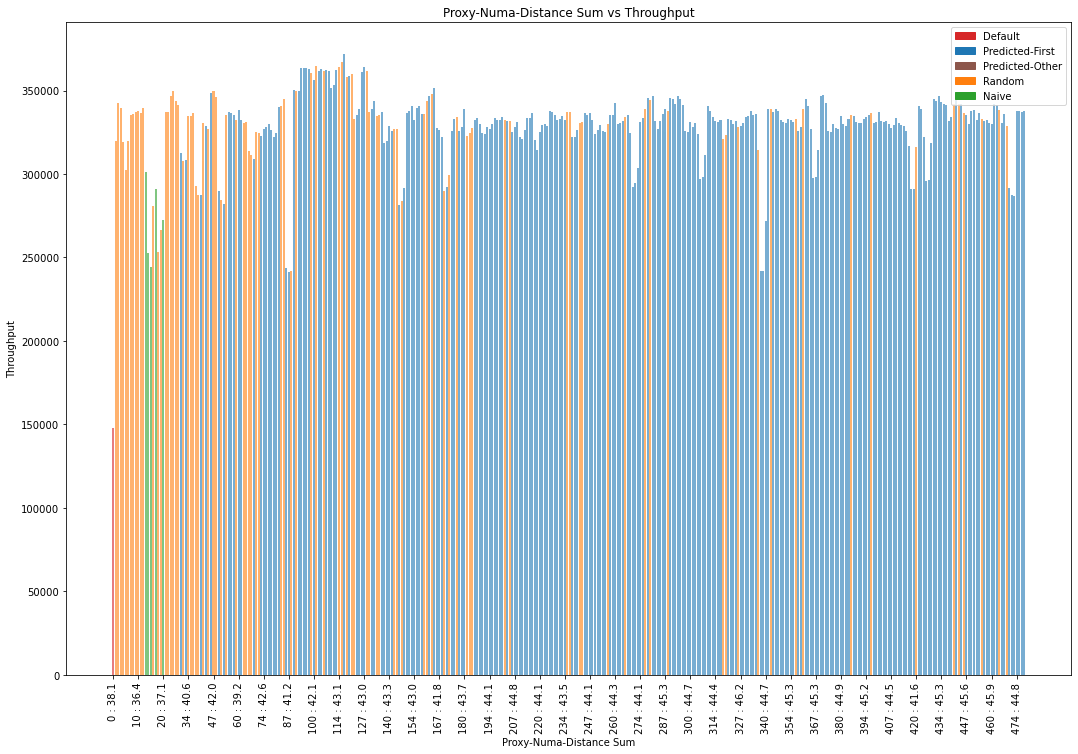

In [18]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:724]

ax.bar(subplot_data['numaSumTime'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Proxy-Numa-Distance Sum', ylabel='Throughput', title='Proxy-Numa-Distance Sum vs Throughput')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::10]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels, loc='upper right')

plt.savefig('numa_sum_highlevel.png')
plt.show()

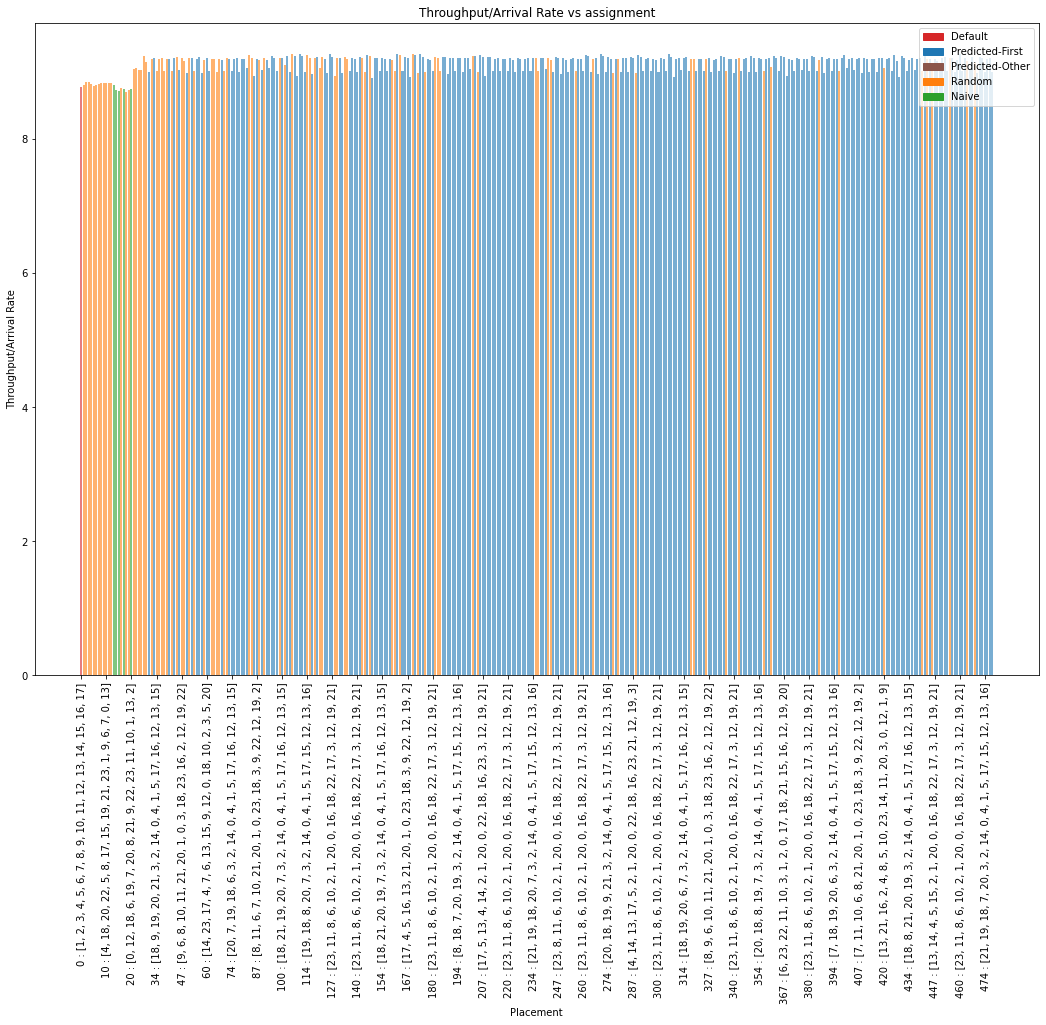

In [19]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:724]

ax.bar(subplot_data['placementActionAugmented'], subplot_data['throughput']/subplot_data['arrivalRate'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput/Arrival Rate', title='Throughput/Arrival Rate vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::10]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels, loc='upper right')

plt.savefig('placement_throughput_ratio_highlevel.png')
plt.show()

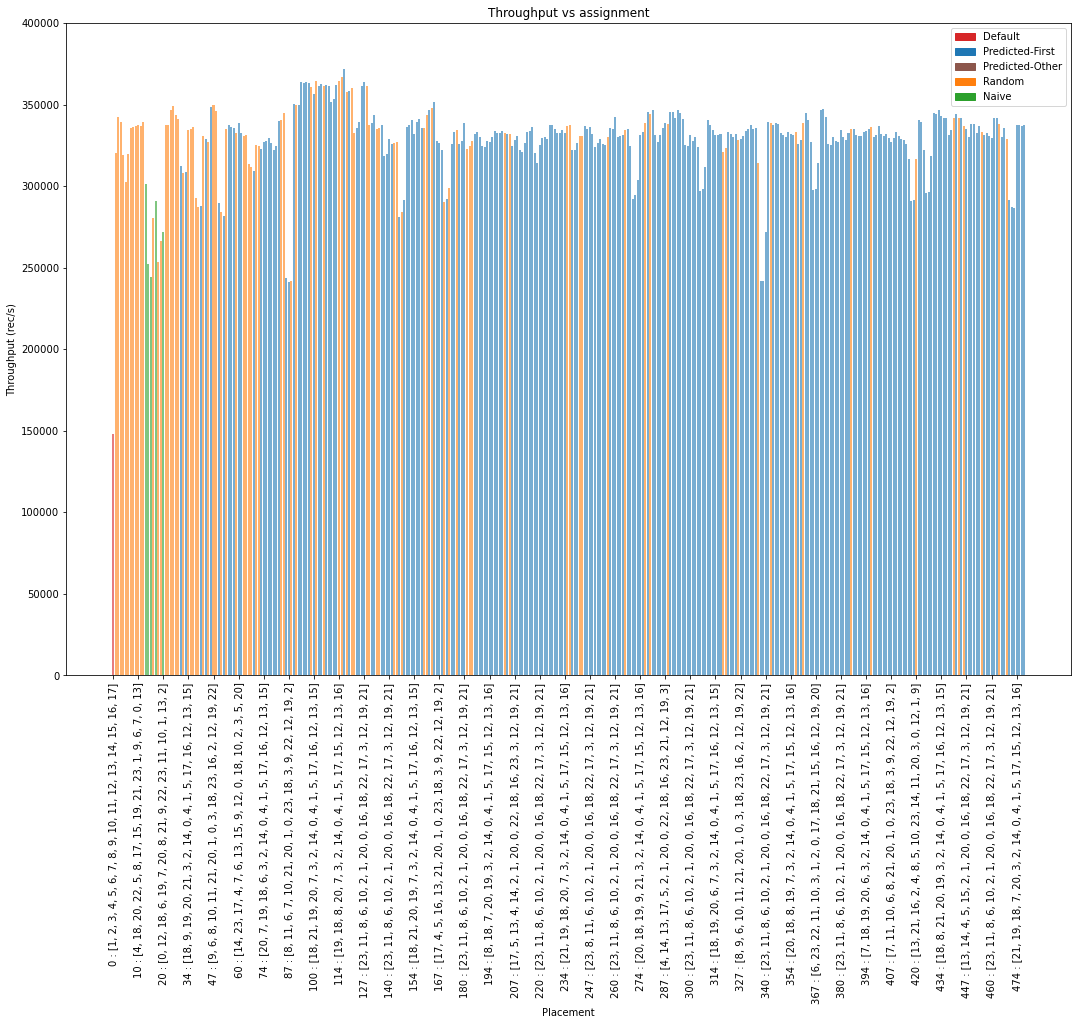

In [20]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:724]

ax.bar(subplot_data['placementActionAugmented'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::10]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)

plt.savefig('placement_throughput_highlevel.png')
plt.show()

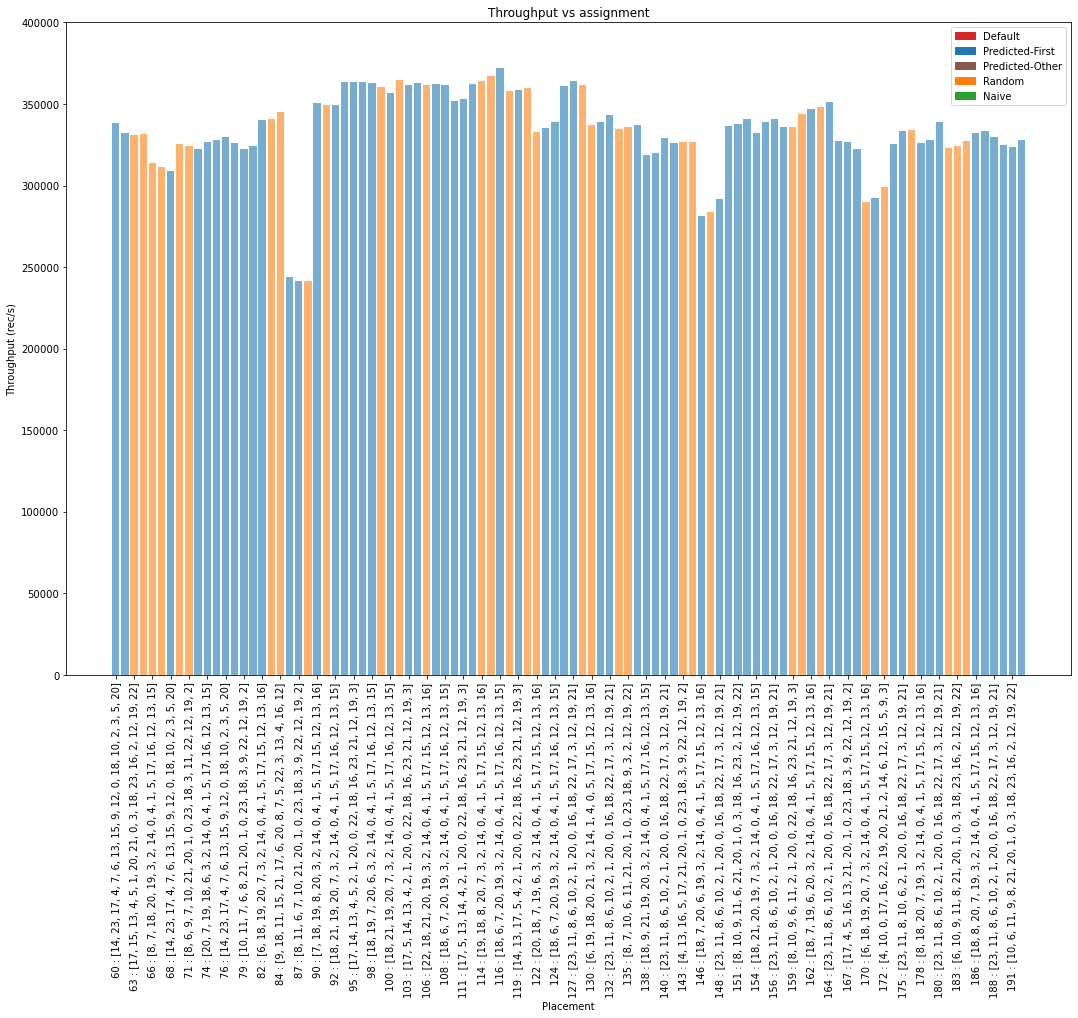

In [21]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[50:150]

ax.bar(subplot_data['placementActionAugmented'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::2]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)

plt.savefig('placement_throughput_highlevel_50_100.png')
plt.show()

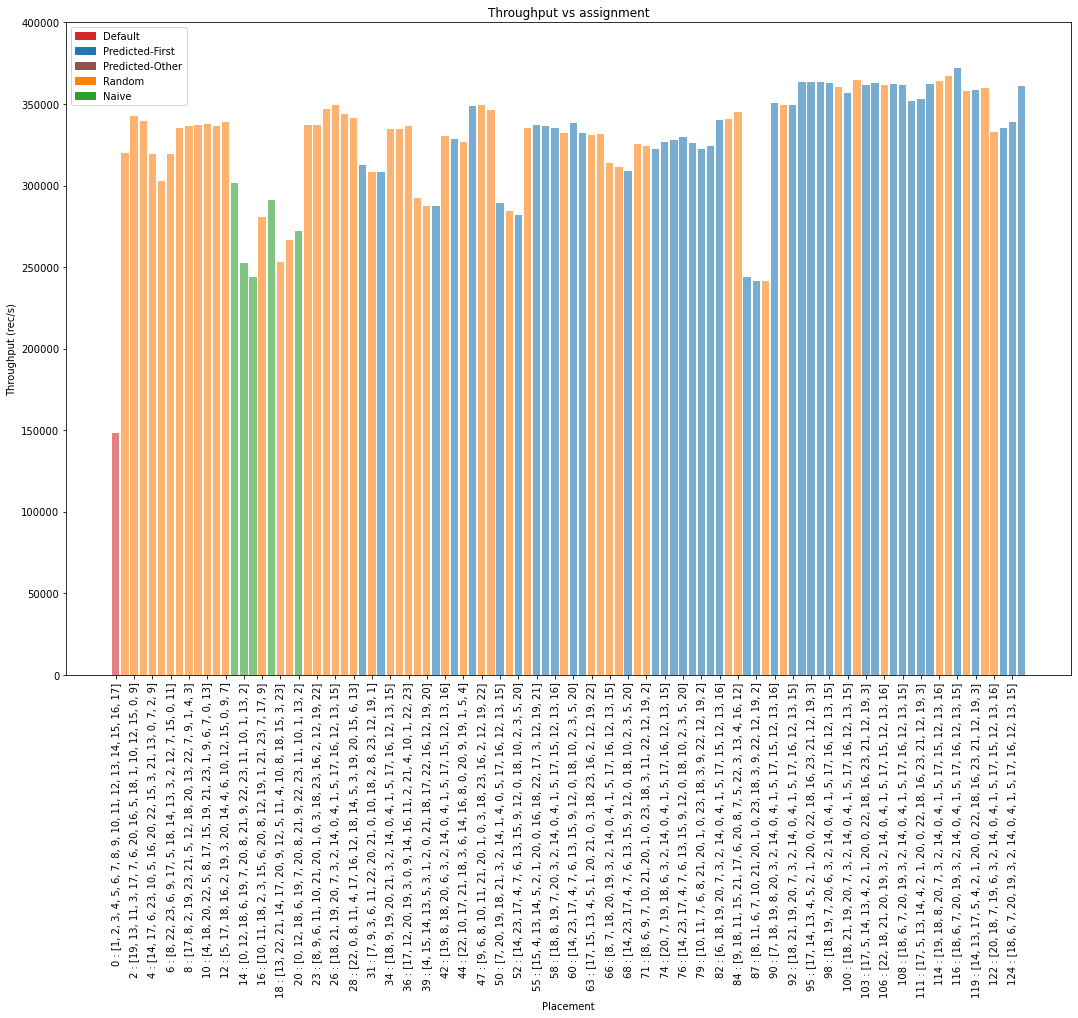

In [22]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:100]

ax.bar(subplot_data['placementActionAugmented'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::2]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)

plt.savefig('placement_throughput_highlevel_0_100.png')
plt.show()

Task Manager CPU Usage
-----------



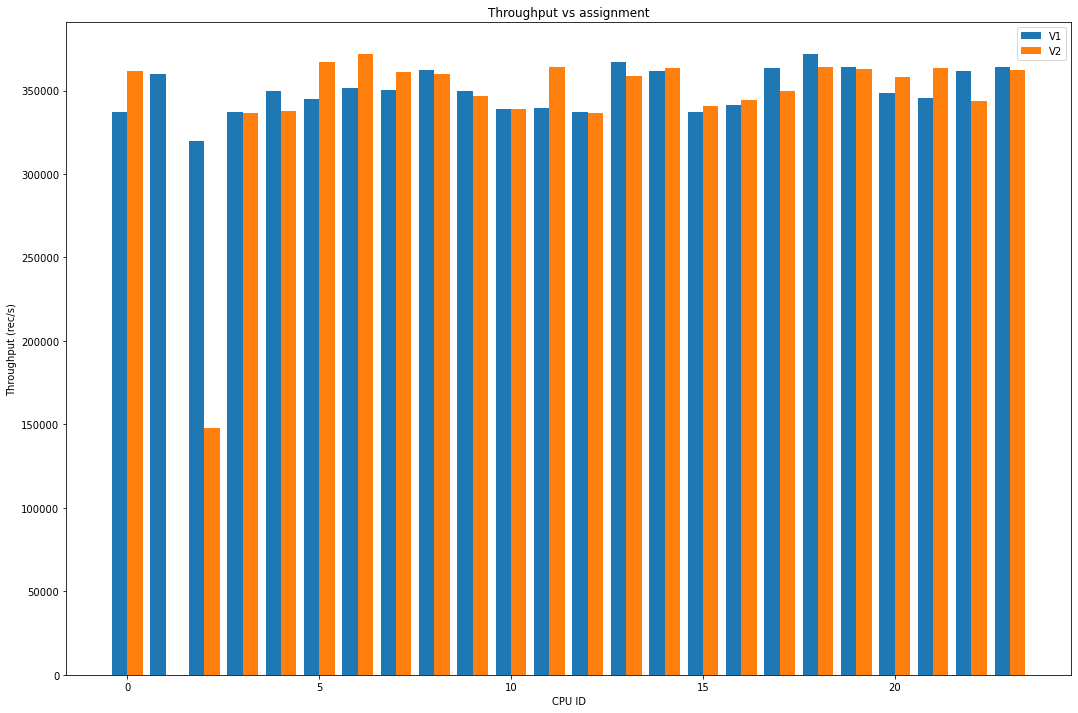

In [23]:
fig,ax = plt.subplots(figsize=(18,12))

width=0.4
ax.bar(processed_state_transitions['v0'] - width/2, processed_state_transitions['throughput'], width, label='V1')
ax.bar(processed_state_transitions['v1'] + width/2, processed_state_transitions['throughput'], width, label='V2')
#ax.plot(task_tot_cpu_data[2]['rel_time'], task_tot_cpu_data[2]['value'])
#ax.plot(task_tot_cpu_data[3]['rel_time'], task_tot_cpu_data[3]['value'])

ax.set(xlabel='CPU ID', ylabel='Throughput (rec/s)',
       title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=0)
ax.legend()
plt.savefig('placement_throughput.png')
plt.show()

In [24]:
state_transitions.head()

,name,time,placementAction,cpuUsageMetrics,cpuFreqMetrics,arrivalRate,throughput,placementType,proxyNumaDistances
0,state_snapshots,1612168470521000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[0.097, 0.016, 0.258, 0.015, 0.316, 0.446, 0.98, 0.978, 0.547, 0.016, 0.022,...","[1438.74, 1242.16, 2100.68, 1200.17, 2101.73, 2100.13, 2100.13, 2100.13, 210...",16876.416667,148113.16,0,"[0.15887581912344984, 0.5295600073985345, 0.47660213500563703, 0.05295897336..."
1,state_snapshots,1612168500419000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18, 16, 8, 23, 21]","[0.005, 0.036, 0.024, 0.962, 0.069, 0.026, 0.063, 0.626, 0.027, 0.317, 0.015...","[2100.31, 2100.59, 1545.47, 2100.13, 1836.46, 2074.95, 2019.02, 2099.66, 210...",36303.850000,320069.15,3,"[0.15969760464123556, 0.5324522286940669, 0.47919914646305617, 0.05323150751..."
2,state_snapshots,1612168530407000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10, 12, 15, 0, 9]","[0.007, 0.007, 0.468, 0.982, 0.022, 0.013, 0.993, 0.058, 0.022, 0.046, 0.011...","[2098.94, 2100.37, 2099.29, 2100.13, 2100.39, 2100.58, 2100.13, 2100.13, 210...",38690.166667,342455.17,3,"[0.15935843618098755, 0.5314108958083108, 0.47826116188594564, 0.05311803800..."
3,state_snapshots,1612168560411000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10, 2, 3, 5, 20]","[0.005, 0.069, 0.036, 0.009, 0.035, 0.011, 0.062, 0.009, 0.015, 0.297, 0.007...","[1869.75, 2100.14, 2098.9, 2100.21, 2100.14, 2100.41, 2099.84, 2101.43, 2102...",38326.200000,339404.95,3,"[0.15780005349886927, 0.5260754161169906, 0.47346643378170256, 0.05259985775..."
4,state_snapshots,1612168590410000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, 13, 0, 7, 2, 9]","[0.004, 0.045, 0.007, 0.011, 0.29, 0.011, 0.033, 0.038, 0.007, 0.004, 0.551,...","[2100.82, 2102.11, 2101.05, 2100.19, 2100.13, 1855.9, 2101.28, 2100.85, 1318...",36186.200000,319340.90,3,"[0.47826404333312367, 0.49646518467435086, 0.44681784979688205, 0.0496482953..."


In [25]:
output_reduced_features = False

In [26]:
if not output_reduced_features:
    state_transitions_for_training = state_transitions.join(placement_actions).join(proxy_numa_distances)
    state_transitions_for_training.drop(columns=state_transitions_for_training.columns[0:4], inplace=True)
    filtered_state_transitions = state_transitions_for_training.loc[state_transitions_for_training['throughput'] > 0.0]
    throughput_col = filtered_state_transitions.pop('throughput')
    filtered_state_transitions.insert(0, 'throughput', throughput_col)
    filtered_state_transitions.drop(columns=filtered_state_transitions.columns[2:4+n_vertices], inplace=True)
    filtered_state_transitions.to_csv('state_transitions_cured.csv', index=False)
    filtered_state_transitions

In [27]:
if not output_reduced_features:
    state_trans_train, state_trans_test = train_test_split(filtered_state_transitions, test_size=0.171)
    state_trans_train.to_csv('state_transitions_cured_train.csv', index=False)
    state_trans_test_final = state_trans_test.drop(columns=['throughput'])
    state_trans_test_final.to_csv('state_transitions_cured_test.csv', index=False)
    state_trans_train

In [28]:
if output_reduced_features:
    state_transitions_for_training = state_transitions.join(placement_actions).join(proxy_numa_distances)
    state_transitions_for_training.drop(columns=state_transitions_for_training.columns[0:4], inplace=True)
    filtered_state_transitions = state_transitions_for_training.loc[state_transitions_for_training['throughput'] > 0.0]
    throughput_col = filtered_state_transitions.pop('throughput')
    filtered_state_transitions.insert(0, 'throughput', throughput_col)
    filtered_state_transitions.drop(columns=filtered_state_transitions.columns[2:4], inplace=True)
    filtered_state_transitions.drop(columns=filtered_state_transitions.columns[
        2+n_vertices:2+n_vertices+(n_vertices*23)+1+66], inplace=True)
    filtered_state_transitions.to_csv('state_transitions_cured.csv', index=False)
    filtered_state_transitions.head(10)

In [29]:
if output_reduced_features:
    state_trans_train, state_trans_test = train_test_split(filtered_state_transitions, test_size=0.171)
    state_trans_train.to_csv('state_transitions_cured_train.csv', index=False)
    state_trans_test_final = state_trans_test.drop(columns=['throughput'])
    state_trans_test_final.to_csv('state_transitions_cured_test.csv', index=False)
    state_trans_train

In [30]:
print("Done.")

Done.
